In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
from collections import Counter
import heapq
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from google.colab import files
import pandas as pd

In [2]:
print("Upload ZIP file containing dataset...")
uploaded = files.upload()
zip_filename = list(uploaded.keys())[0]

extract_folder = "dataset"
with ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)
print(f"Extracted images to folder: {extract_folder}")

image_files = []
for root, dirs, files in os.walk(extract_folder):
    for f in files:
        if f.lower().endswith(('.jpg','.jpeg','.png')):
            image_files.append(os.path.join(root, f))

if len(image_files) == 0:
    raise ValueError("No images found in dataset.")
print(f"Found {len(image_files)} images.")

Upload ZIP file containing dataset...


Saving archive (7).zip to archive (7).zip
Extracted images to folder: dataset
Found 4165 images.


In [3]:
class Node:
    def __init__(self, val, freq):
        self.val = val
        self.freq = freq
        self.left = None
        self.right = None
    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(symbols):
    heap = [Node(val,freq) for val,freq in symbols.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        node1 = heapq.heappop(heap)
        node2 = heapq.heappop(heap)
        merged = Node(None, node1.freq + node2.freq)
        merged.left = node1
        merged.right = node2
        heapq.heappush(heap, merged)
    return heap[0]

def build_huffman_code(node, prefix="", code={}):
    if node is None:
        return
    if node.val is not None:
        code[node.val] = prefix
    build_huffman_code(node.left, prefix+"0", code)
    build_huffman_code(node.right, prefix+"1", code)
    return code

In [4]:
def zigzag_scan(block):
    idx_order = sorted(((x,y) for x in range(8) for y in range(8)), key=lambda s: s[0]+s[1])
    return np.array([block[i,j] for i,j in idx_order])

def inverse_zigzag(vec):
    block = np.zeros((8,8))
    idx_order = sorted(((x,y) for x in range(8) for y in range(8)), key=lambda s: s[0]+s[1])
    for (i,j), val in zip(idx_order, vec):
        block[i,j] = val
    return block

In [5]:
def rle_encode(arr):
    encoded = []
    prev = arr[0]
    count = 1
    for a in arr[1:]:
        if a == prev:
            count += 1
        else:
            encoded.append((prev, count))
            prev = a
            count = 1
    encoded.append((prev, count))
    return encoded

def rle_decode(rle):
    out = []
    for val,count in rle:
        out.extend([val]*count)
    return np.array(out)

In [6]:
def dct2(block):
    return cv2.dct(block.astype(np.float32))

def idct2(block):
    return cv2.idct(block.astype(np.float32))

In [7]:
# Step 6: Quantization
Q50 = np.array([
[16,11,10,16,24,40,51,61],
[12,12,14,19,26,58,60,55],
[14,13,16,24,40,57,69,56],
[14,17,22,29,51,87,80,62],
[18,22,37,56,68,109,103,77],
[24,35,55,64,81,104,113,92],
[49,64,78,87,103,121,120,101],
[72,92,95,98,112,100,103,99]
])

def scale_quant_matrix(Q, quality):
    if quality < 50:
        S = 5000/quality
    else:
        S = 200 - 2*quality
    Q_scaled = np.floor((Q*S + 50)/100)
    Q_scaled[Q_scaled==0] = 1
    return Q_scaled

In [8]:
# Step 7: Compression / Decompression
def compress_channel(channel, Q):
    h, w = channel.shape
    padded_h = ((h-1)//8 + 1)*8
    padded_w = ((w-1)//8 + 1)*8
    padded = np.zeros((padded_h, padded_w))
    padded[:h,:w] = channel
    padded -= 128
    quant = scale_quant_matrix(Q50, Q)
    blocks = []
    for i in range(0,padded_h,8):
        for j in range(0,padded_w,8):
            block = padded[i:i+8,j:j+8]
            dct_block = dct2(block)
            q_block = np.round(dct_block/quant)
            zz = zigzag_scan(q_block)
            rle = rle_encode(zz)
            blocks.append(rle)
    # Assuming Huffman code and bitstream would be generated here
    # For now, returning dummy values and a placeholder comp_size
    huff_code = {}
    # Placeholder: Calculate a dummy compressed size based on the number of RLE blocks
    # In a real implementation, this would be the length of the Huffman encoded bitstream
    bitstream = [0] * len(blocks) * 10 # Just a placeholder to avoid division by zero
    return blocks, quant, huff_code, bitstream, padded_h, padded_w

In [9]:
# Huffman code
def decompress_channel(blocks, quant, huff_code, padded_h, padded_w, h, w):
    channel_rec = np.zeros((padded_h, padded_w))
    idx = 0
    for i in range(0,padded_h,8):
        for j in range(0,padded_w,8):
            rle = blocks[idx]
            idx += 1
            zz = rle_decode(rle)
            q_block = inverse_zigzag(zz)
            dequant = q_block*quant
            idct_block = idct2(dequant)
            channel_rec[i:i+8,j:j+8] = idct_block
    channel_rec += 128
    return np.clip(channel_rec[:h,:w], 0, 255)

In [10]:
# Step 8: Experiment
quality_factors = [90,70,50,30,10]
results = []

In [11]:
# For report, display first image only
displayed = False

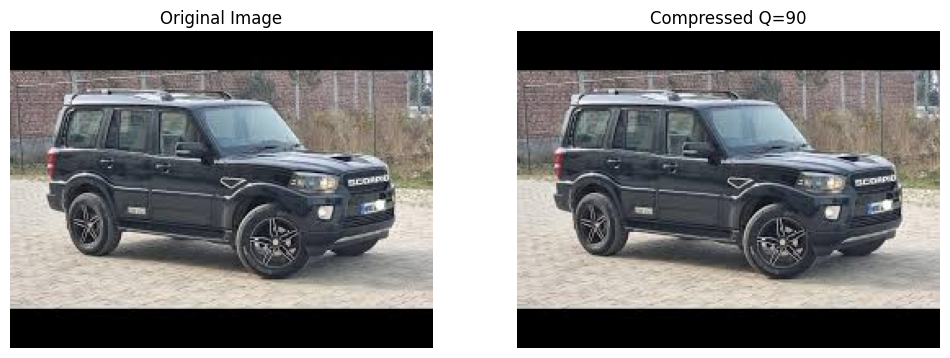

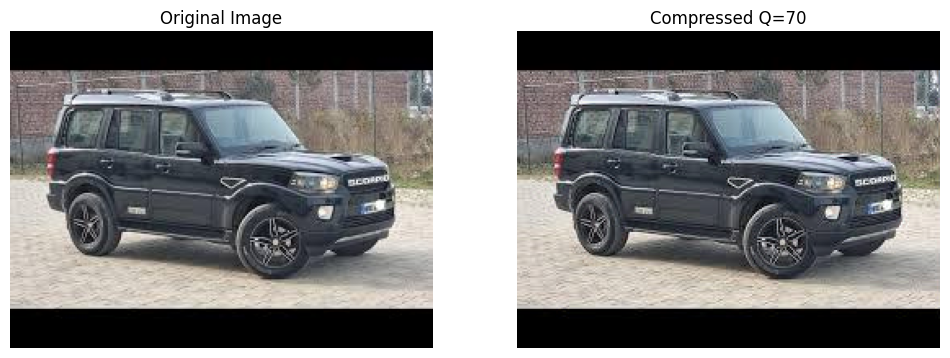

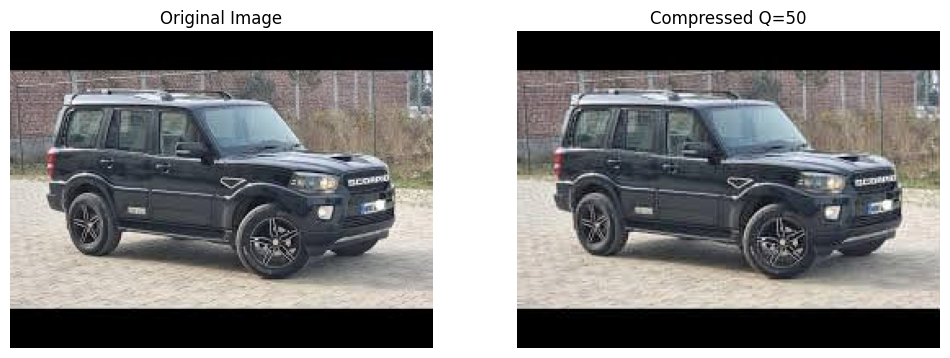

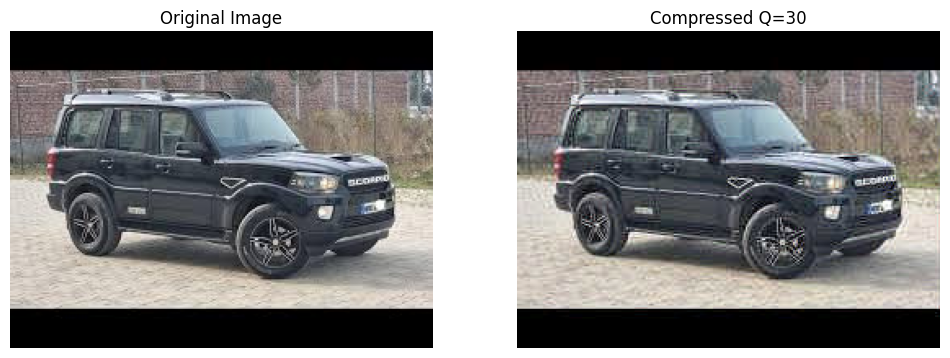

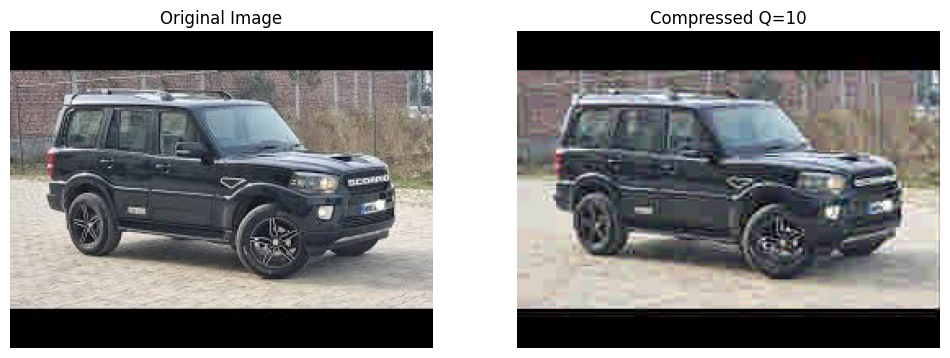

In [ ]:
for img_path in image_files:
    img_name = os.path.basename(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    for Q in quality_factors:
        reconstructed_channels = []
        for c in range(3):
            blocks, quant, huff_code, bitstream, ph, pw = compress_channel(img[:,:,c], Q)
            rec = decompress_channel(blocks, quant, huff_code, ph, pw, h, w)
            reconstructed_channels.append(rec)
        rec_img = np.stack(reconstructed_channels, axis=2).astype(np.uint8)

        # Metrics
        psnr_val = psnr(img, rec_img)
        ssim_val = ssim(img, rec_img, channel_axis=2)
        orig_size = img.size*8
        comp_size = len(bitstream)
        cr = orig_size / comp_size
        bpp = comp_size/(h*w)
        results.append([img_name, Q, cr, bpp, psnr_val, ssim_val])

        # Display only the first image for report
        if not displayed:
            plt.figure(figsize=(12,6))
            plt.subplot(1,2,1)
            plt.imshow(img)
            plt.title("Original Image")
            plt.axis('off')
            plt.subplot(1,2,2)
            plt.imshow(rec_img)
            plt.title(f"Compressed Q={Q}")
            plt.axis('off')
            plt.show()
    displayed = True

# ---------------- Step 9: Results Table ----------------
df = pd.DataFrame(results, columns=['Image','Quality','CR','bpp','PSNR','SSIM'])
print(df)